# Testing Ensemble Capability with Synthetic Data
------------

In order to test our ensemble modeling capability, we first contruct a synthetic dataset from the weighted sum of the output of a set of constituent models, wherein each of $N = 3$ models is prescribed a weight $w_i$, such that $0 \leq w_i \leq 1$ and $\displaystyle \sum_{i = 1}^N w_i = 1$. We then attempt to recover these generating weights by calibrating an ensemble of the constituent models to the synthetically generated dataset.

### Load dependencies and set up the notebook environment

In [1]:
import os

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyciemss.PetriNetODE.interfaces import load_petri_model
from pyciemss.PetriNetODE.interfaces import sample as sample_petri
from pyciemss.PetriNetODE.interfaces import setup_model as setup_model_petri
from pyciemss.PetriNetODE.interfaces import intervene as intervene_petri
from pyciemss.PetriNetODE.interfaces import calibrate as calibrate_petri

from pyciemss.Ensemble.interfaces import setup_model as setup_model_ensemble
from pyciemss.Ensemble.interfaces import reset_model as reset_model_ensemble
from pyciemss.Ensemble.interfaces import intervene as intervene_ensemble
from pyciemss.Ensemble.interfaces import sample as sample_ensemble
from pyciemss.Ensemble.interfaces import calibrate as calibrate_ensemble
from pyciemss.Ensemble.interfaces import optimize as optimize_ensemble

### Load data, set train and test intervals
Each date in the dataset is associated with three status metrics for COVID-19 in the United States: case census, hospitalization census, and cumulative deaths. 

In [2]:
print(os.getcwd())
# Load the data as a torch tensor.
DATA_PATH = "covid_data/"
data_filename = "US_case_hospital_death.csv"
data_filename = os.path.join(DATA_PATH, data_filename)

data = pd.read_csv(data_filename)

# Clip off the first 2 months of data
data_total_population = 331893745
train_start_date = "2021-12-01"
test_start_date = "2022-03-01"
test_end_date = "2022-04-01"

# data

/Users/altu809/Projects/pyciemss/notebook/april_ensemble


### Define a function to prepare train and test data

In [3]:
def get_train_test_data(data: pd.DataFrame, train_start_date: str, test_start_date: str, test_end_date: str) -> pd.DataFrame:
    train_df = data[(data['date'] >= train_start_date) & (data['date'] < test_start_date)]
    train_data = [0] * train_df.shape[0]
    start_time = train_df.index[0]

    train_cases = np.array(train_df["case_census"].astype("float")) / data_total_population
    train_timepoints = np.array(train_df.index.astype("float"))

    test_df = data[(data['date'] >= test_start_date) & (data['date'] < test_end_date)]
    test_cases = np.array(test_df["case_census"].astype("float")) / data_total_population
    test_timepoints = np.array(test_df.index.astype("float"))

    for time, row in train_df.iterrows():
        row_dict = {}
        row_dict["Cases"] = row["case_census"] / data_total_population
        row_dict["Dead"] = row["cumulative_deaths"] / data_total_population
        if row["hospital_census"] > 0:
            row_dict["Hospitalizations"] = row["hospital_census"] / data_total_population

        index = time - start_time
        train_data[index] = (float(time), row_dict)
    
    all_timepoints = np.concatenate((train_timepoints, test_timepoints))

    return train_data, train_cases, train_timepoints, test_cases, test_timepoints, all_timepoints

## Set up each model
Each model is loaded as a Petri Model with uniformally distributed uncertainty in each parameter value, and then assigned a start state as well as a solution mapping from state variables to the three data metrics: case census, hospitalization census, and cumulative deaths.

### Set up Model 1

In [4]:
MIRA_PATH = "../../test/models/april_ensemble_demo/"

filename1 = "BIOMD0000000955_template_model.json"
filename1 = os.path.join(MIRA_PATH, filename1)

model1 = load_petri_model(filename1, add_uncertainty=True)

#model1

### Define a start state for Model 1
Note: Assumptions made in defining these mappings are listed, but should be revisited and revised in the future.

In [5]:
def create_start_state1(data, start_date, total_pop):
    start_state = data.set_index('date').loc[start_date].to_dict()

    returned_state = {}
    returned_state["Extinct"] = start_state['cumulative_deaths']
    
    # Assume Threatened maps to hospitalizations, and, if no hosp. data, assume 1 hosp. per 100 recorded cases
    if np.isnan(start_state['hospital_census']):
        returned_state["Threatened"] = start_state['case_census'] / 100
    else:
        returned_state["Threatened"] = start_state['hospital_census']

    # Assume one undetected case per detected case, and evenly distribute across each category of infectiousness 
    returned_state["Diagnosed"] = start_state['case_census'] / 2
    returned_state["Recognized"] = start_state['case_census'] / 2
    returned_state['Infected'] = start_state['case_census'] / 2 # * 10
    returned_state['Ailing'] = start_state['case_census'] / 2 # returned_state["Threatened"] * 100

    # Assume ten individuals are Healed for every one death
    returned_state['Healed'] = start_state['cumulative_deaths'] * 10
    returned_state['Susceptible'] =  total_pop - sum(returned_state.values())
    #print(returned_state)
    assert(returned_state['Susceptible'] > 0)
    return {k:v/total_pop for k, v in returned_state.items()}

In [6]:
test_dates = pd.date_range(start=train_start_date, end=test_end_date, freq="1D")
test_dates = [date.strftime("%Y-%m-%d") for date in test_dates[1:-1]]

print("train_start_date", train_start_date)

# Check all dates to make sure no initial values are negative
[create_start_state1(data, date, data_total_population) for date in test_dates]

# Create the start state for Model 1 in terms of percent of population
start_state1 = create_start_state1(data, train_start_date, data_total_population)
start_state1

train_start_date 2021-12-01


{'Extinct': 0.002354530664625813,
 'Threatened': 0.00012599815642804597,
 'Diagnosed': 0.0014301113146919957,
 'Recognized': 0.0014301113146919957,
 'Infected': 0.0014301113146919957,
 'Ailing': 0.0014301113146919957,
 'Healed': 0.023545306646258125,
 'Susceptible': 0.96825371927392}

In [7]:
# View the start state in terms of population (number of individuals), rather than percent of population
{k: v*data_total_population for k, v in start_state1.items()}

{'Extinct': 781454.0,
 'Threatened': 41818.0,
 'Diagnosed': 474645.0,
 'Recognized': 474645.0,
 'Infected': 474645.0,
 'Ailing': 474645.0,
 'Healed': 7814539.999999999,
 'Susceptible': 321357353.0}

### Define a solution mapping for Model 1

In [8]:
# Taken from "observables" in JSON file
def solution_mapping1(model1_solution: dict) -> dict:
    mapped_dict = {}
    mapped_dict["Cases"] = model1_solution["Diagnosed"] + model1_solution["Recognized"]
    mapped_dict["Hospitalizations"] = model1_solution["Threatened"]
    mapped_dict["Dead"] = model1_solution["Extinct"]
    return mapped_dict

### *NOTE - Assumptions made to define start states (especially) and solution mappings should be revisited (1) for accuracy: do these choices make sense? are they supported by the literature? and (2) to ensure we are not violating any conservation of mass principles.*
(In progress) *It would also be a good idea to implement a test to assert that the sum of all state variables is equal to the total population at each time point.* 

### Set up Model 2
Note: Model 2 has a hard-coded value for US total population. A test could be implemented to catch and adjust for this.

In [9]:
filename2 = "BIOMD0000000960_template_model.json"
filename2 = os.path.join(MIRA_PATH, filename2)
 
model2 = load_petri_model(filename2, add_uncertainty=True)

# TODO: put this into the interfaces
mira_start_state2 = {k[0]: v.data['initial_value'] for k, v in model2.G.variables.items()}

#model2

/Users/altu809/Projects/pyciemss/src/pyciemss/PetriNetODE/base.py:415: UserWarning: Parameter delta_A has value 0.0 <= 0.0 and will be set to Uniform(0, 0.1)
  warnings.warn(warnings_string)
/Users/altu809/Projects/pyciemss/src/pyciemss/PetriNetODE/base.py:415: UserWarning: Parameter mira_param_9 has value 0.0 <= 0.0 and will be set to Uniform(0, 0.1)
  warnings.warn(warnings_string)


In [10]:
# Pull the start state from the MIRA model
mira_start_state2

{'Susceptible': 9900000.0,
 'Exposed': 36600.0,
 'Infectious': 732.0,
 'Asymptomatic': 2196.0,
 'Hospitalized': 0.0,
 'Recovered': 0.0,
 'Deceased': 0.0}

### Define a solution mapping for Model 2 (in terms of percent of hard-coded Model 2 population)

In [11]:
# model2_total_population = sum(mira_start_state2.values()) # this value is off

# Use hard-coded Total USA population from the model json file
model2_total_population = model2.G.template_model.parameters['Total_pop_USA'].value 

def solution_mapping2(model2_solution: dict) -> dict:
    mapped_dict = {}
    mapped_dict["Cases"] = model2_solution["Infectious"] / model2_total_population
    mapped_dict["Hospitalizations"] = model2_solution["Hospitalized"] / model2_total_population
    mapped_dict["Dead"] = model2_solution["Deceased"] / model2_total_population
    return mapped_dict

### Define a start state for Model 2

In [12]:
def create_start_state2(data, start_date, m2_total_pop, data_total_pop):
    start_state = data.set_index('date').loc[start_date].to_dict()

    returned_state = {}
    returned_state["Deceased"] = start_state['cumulative_deaths']
    
    # If no hospitalization data, assume 1 hospitalized individual per 100 recorded cases
    if np.isnan(start_state['hospital_census']):
        returned_state["Hospitalized"] = start_state['case_census'] / 100
    else:
        returned_state["Hospitalized"] = start_state['hospital_census']
    
    # Assume Infectious maps to recorded cases
    returned_state["Infectious"] = start_state['case_census']

    # Assume one Asymptomatic (unrecorded) case per recorded case, and that twice as many individuals
    # are Exposed (but not yet infectious) as there are recorded cases  
    returned_state['Exposed'] = start_state['case_census'] * 2 # * 20
    returned_state['Asymptomatic'] = start_state['case_census'] # * 10

    # Assume ten individuals are Recovered for every one death
    returned_state['Recovered'] = start_state['cumulative_deaths'] * 10

    returned_state['Susceptible'] =  data_total_pop - sum(returned_state.values())
    assert(returned_state['Susceptible'] > 0)
    return {k:v*m2_total_pop/data_total_pop for k, v in returned_state.items()}

In [13]:
print("train_start_date", train_start_date)
[create_start_state2(data, date, model2_total_population, data_total_population) for date in test_dates]
start_state2 = create_start_state2(data, train_start_date, model2_total_population, data_total_population)
start_state2

train_start_date 2021-12-01


{'Deceased': 772756.9641301917,
 'Hospitalized': 41352.594939684685,
 'Infectious': 938725.0669638261,
 'Exposed': 1877450.1339276521,
 'Asymptomatic': 938725.0669638261,
 'Recovered': 7727569.641301917,
 'Susceptible': 315903420.5317729}

## Set up Model 3

In [14]:
filename3 = "BIOMD0000000983_template_model.json"
filename3 = os.path.join(MIRA_PATH, filename3)

model3 = load_petri_model(filename3, add_uncertainty=True)

# TODO: put this into the interfaces
mira_start_state3 = {k[0]: v.data['initial_value'] for k, v in model3.G.variables.items()}
mira_start_state3['Deceased'] = 0.0

model3

ScaledBetaNoisePetriNetODESystem(
	mira_param_0 = Uniform(low: 7.614000097078133e-09, high: 9.306000414710525e-09),
	mira_param_1 = Uniform(low: 1.5228000194156266e-08, high: 1.861200082942105e-08),
	mira_param_2 = Uniform(low: 1.9035000242695332e-09, high: 2.326500103677631e-09),
	mira_param_3 = Uniform(low: 3.8070000485390665e-09, high: 4.653000207355262e-09),
	mira_param_4 = Uniform(low: 0.019285714253783226, high: 0.023571427911520004),
	mira_param_5 = Uniform(low: 0.035999998450279236, high: 0.04399999976158142),
	mira_param_6 = Uniform(low: 0.14399999380111694, high: 0.17599999904632568),
	mira_param_7 = Uniform(low: 0.09000000357627869, high: 0.10999999940395355),
	mira_param_8 = Uniform(low: 0.22499999403953552, high: 0.2750000059604645),
	mira_param_9 = Uniform(low: 0.044999998062849045, high: 0.054999999701976776),
	mira_param_10 = Uniform(low: 0.015300000086426735, high: 0.018699999898672104),
	pseudocount = 1.0
)

### Define a solution mapping for Model 3

In [15]:
model3_total_population = sum(mira_start_state3.values())

# Get hospitalization rate from the model
hosp_ratio = model3.G.template_model.parameters['h'].value 

def solution_mapping3(model3_solution: dict) -> dict:
    mapped_dict = {}
    # Ideally we would make better use of this distinction between "reported" and "unreported".
    # However, as other models don't include this distinction, we must instead sum them together to make solution outputs comparable.
    mapped_dict["Cases"] = model3_solution["Infected_reported"] / model3_total_population
    mapped_dict["Hospitalizations"] = (model3_solution["Infected_reported"] * hosp_ratio) / model3_total_population # (model3_solution["Infected_unreported"] * hosp_ratio) / model3_total_population
    mapped_dict["Dead"] = (model3_solution["Deceased"]) / model3_total_population
    return mapped_dict


In [16]:
# Pull the start state from the MIRA model
mira_start_state3

{'Susceptible_unconfined': 66990000.0,
 'Exposed': 112.0,
 'Infected_reported': 12.0,
 'Infected_unreported': 50.0,
 'Quarantined': 36.0,
 'Recovered': 0.0,
 'Deceased': 0.0}

## Define a start state for Model 3

In [17]:
def create_start_state3(data, start_date, m3_total_pop, data_total_pop):
    start_state = data.set_index('date').loc[start_date].to_dict()

    returned_state = {}
    returned_state["Deceased"] = start_state['cumulative_deaths']
    
    # Hospitalization rates in model3 are just a scalar multiple of case_census. 
    # Initializing here may lead to contradiction for the Infected_reported variable
    # Instead assume initial quarantined individuals are equal to those hospitalized in data
    if np.isnan(start_state['hospital_census']):
        returned_state["Quarantined"] = start_state['case_census'] * 0.01
    else:
        returned_state["Quarantined"] = start_state['hospital_census']
    
    returned_state["Infected_reported"] = start_state['case_census']
    
    # Assume one unreported case per recorded case
    returned_state["Infected_unreported"] = start_state['case_census']
    
    # Assume twice as many individuals are Exposed (but not yet infectious) as recorded cases
    returned_state['Exposed'] = start_state['case_census'] * 2
    
    # Assume ten individuals are Recovered for every one death
    returned_state['Recovered'] = start_state['cumulative_deaths'] * 10
    
    returned_state['Susceptible_confined'] = 0
    returned_state['Susceptible_unconfined'] =  data_total_pop - sum(returned_state.values())
    assert(returned_state['Susceptible_unconfined'] > 0)
    return {k:v*m3_total_pop/data_total_pop for k, v in returned_state.items()}

In [18]:
[create_start_state3(data, date, model3_total_population, data_total_population) for date in test_dates]
start_state3 = create_start_state3(data, train_start_date, model3_total_population, data_total_population)
start_state3

{'Deceased': 157730.50367472277,
 'Quarantined': 8440.642958727649,
 'Infected_reported': 191606.91458918576,
 'Infected_unreported': 191606.91458918576,
 'Exposed': 383213.8291783715,
 'Recovered': 1577305.0367472277,
 'Susceptible_confined': 0.0,
 'Susceptible_unconfined': 64480306.15826257}

## Compare the start states and solution mappings of each model, check that we are using the same initial population for each

In [19]:
print("start_state1-Scaled")
display({k: v*data_total_population for k, v in start_state1.items()})

print(" ")

print("start_state2-Scaled")
display({k: v*data_total_population/model2_total_population for k, v in start_state2.items()})

print(" ")

print("start_state3-Scaled")
display({k: v*data_total_population/model3_total_population for k, v in start_state3.items()})


start_state1-Scaled


{'Extinct': 781454.0,
 'Threatened': 41818.0,
 'Diagnosed': 474645.0,
 'Recognized': 474645.0,
 'Infected': 474645.0,
 'Ailing': 474645.0,
 'Healed': 7814539.999999999,
 'Susceptible': 321357353.0}

 
start_state2-Scaled


{'Deceased': 781454.0,
 'Hospitalized': 41818.0,
 'Infectious': 949290.0,
 'Exposed': 1898580.0,
 'Asymptomatic': 949290.0,
 'Recovered': 7814540.0,
 'Susceptible': 319458773.0}

 
start_state3-Scaled


{'Deceased': 781454.0,
 'Quarantined': 41818.0,
 'Infected_reported': 949290.0,
 'Infected_unreported': 949290.0,
 'Exposed': 1898580.0,
 'Recovered': 7814540.0,
 'Susceptible_confined': 0.0,
 'Susceptible_unconfined': 319458772.99999994}

In [20]:
print(f"Model 1 mapped start state is {solution_mapping1(start_state1)}")
print(f"Model 2 mapped start state is {solution_mapping2(start_state2)}")
print(f"Model 3 mapped start state is {solution_mapping3(start_state3)}")

Model 1 mapped start state is {'Cases': 0.0028602226293839915, 'Hospitalizations': 0.00012599815642804597, 'Dead': 0.002354530664625813}
Model 2 mapped start state is {'Cases': 0.0028602226293839915, 'Hospitalizations': 0.00012599815642804597, 'Dead': 0.002354530664625813}
Model 3 mapped start state is {'Cases': 0.0028602226293839915, 'Hospitalizations': 0.00014301113146919958, 'Dead': 0.002354530664625813}


In [21]:
print(f"Model 2 total population is {model2_total_population}")
print(f"Model 3 total population is {model3_total_population}")
print("These values are not equal, initiate reachback to TA1 and TA2!")

Model 2 total population is 328200000.0
Model 3 total population is 66990210.0
These values are not equal, initiate reachback to TA1 and TA2!


In [22]:
# Assert that all of the variables in the solution mappings are the same.
assert(set(solution_mapping1(start_state1).keys()) 
       == set(solution_mapping2(start_state2).keys())
       == set(solution_mapping3(start_state3).keys()))

## Setup some plotting utilities

In [23]:
def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_xlabel('Time since start of pandemic (days)')
    ax.set_ylabel('Cases (Prop. of Population)')
    ax.set_yscale('log')
    return ax

def plot_trajectory(prediction, tspan, ax=None, alpha=0.2, color="black", **kwargs):
    tspan = torch.as_tensor(tspan)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    I = prediction["Cases_sol"].detach().numpy().squeeze()
    ax.plot(tspan, I, alpha=0.5, lw=2, color=color, **kwargs)
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    return ax

def plot_predictive(prediction, tspan, var_name="Cases_sol", ax=None, title=None, alpha=0.2, color="black", **kwargs):
    tspan = torch.as_tensor(tspan)
    indeces = torch.ones_like(tspan).bool()
    
    I_low = torch.quantile(prediction[var_name], 0.05, dim=0).detach().numpy()
    I_up = torch.quantile(prediction[var_name], 0.95, dim=0).detach().numpy()

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    if title:
        ax.set_title(title)

    ax.fill_between(tspan[indeces], I_low[indeces], I_up[indeces], alpha=alpha, color=color, **kwargs)

    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    return ax

def plot_observations(data, tspan,  ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None, ):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ax.plot(tspan, data, color, alpha=alpha, lw=lw, marker=marker, label=label)
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    
    return ax

from pyro.distributions import Dirichlet
import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)

# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

# Adapted from https://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/
def plot_weights(samples, ax=None, title=None, concentration=20, nlevels=200, subdiv=7, **kwargs):
    import math
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)

    points = torch.tensor(np.array([(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]))
    points /= torch.sum(points, dim=1, keepdim=True)

    alpha = samples * concentration
    vals = torch.stack([torch.exp(Dirichlet(alpha).log_prob(points[i,:])) for i in range(points.shape[0])])
    vals /= torch.max(vals, dim=0, keepdim=True)[0]
    vals = torch.sum(vals, dim=1)
    vals /= torch.sum(vals)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    if title:
        ax.set_title(title)

    mappable = ax.tricontourf(trimesh, vals, nlevels, cmap='jet', **kwargs)
    ax.axis('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 0.75**0.5)
    ax.axis('off')

    # label vertices "Model 1", "Model 2", and "Model 3"
    ax.text(-0.05, -0.08, 'Model 1', fontsize=14, ha='left')
    ax.text(1.05, -0.08, 'Model 2', fontsize=14, ha='right')
    ax.text(0.5,  0.75**0.5+0.03, 'Model 3', fontsize=14, ha='center')
    # add a colorbar with no numbers
    plt.colorbar(mappable, ticks=[], pad=0.1, ax=ax)
    return ax

# Begin data synthesis
Set up each model with an intervention to fix parameter values, and generate data from each. This data is then combined into a single data set using prescribed weights. 

In [24]:
# Create dictionary to organize solutions from each model
synth_data_dict = {}

### Define time points for synthetic data

In [25]:
# Set up timepoints
from pyciemss.utils import get_tspan

N_t = 100
t_points = get_tspan(1, N_t, 10*(N_t - 1) + 1) #get_tspan(1, all_timepoints[-1], len(all_timepoints)) # all_timepoints
#number of terms = 1 + (end - start)/step_size

start_t = 0

# Note that we cannot intervene at a previously existing timepoint, or odeint will complain.
Num_param = 16
intervene_t = get_tspan(0.1, 0.9, Num_param)
#print("t_points", t_points)
#print("intervene_t", intervene_t)

## Set up Model 1 and intervene with fixed parameters (NEEDS CORRECTION)

In [26]:
# Choose model parameter distributions to intervene on selected specific values

# Note that we cannot intervene at a previously existing timepoint, or odeint will complain.
# Intervention format: (time, parameter, value)

model1_rate_parameter_intervention = [
    (intervene_t[0], "beta", 0.01),
    (intervene_t[1], "gamma", 0.49),
    (intervene_t[2], "delta", 0.011),
    (intervene_t[3], "alpha", 0.61),
    (intervene_t[4], "epsilon", 0.17),
    (intervene_t[5], "zeta", 0.13),
    (intervene_t[6], "XXlambdaXX", 0.036),
    (intervene_t[7], "eta", 0.13),
    (intervene_t[8], "rho", 0.036),
    (intervene_t[9], "theta", 0.39),
    (intervene_t[10], "kappa", 0.017),
    (intervene_t[11], "mu", 0.017),
    (intervene_t[12], "nu", 0.028),
    (intervene_t[13], "xi", 0.017),
    (intervene_t[14], "tau", 0.009),
    (intervene_t[15], "sigma", 0.017)
]
print(model1_rate_parameter_intervention)


# Setup model with initial value
setup_model1 = setup_model_petri(model1, start_time=start_t, start_state=start_state1)#, solution_mappings=[solution_mapping1])

# Create intevened model
intervened_model1 = intervene_petri(setup_model1, model1_rate_parameter_intervention)
print(intervened_model1)

# Simulate model predictions by sampling 1 prediction from the intervened model
N_samples = 1
model1_prediction = sample_petri(intervened_model1, timepoints=t_points, num_samples = N_samples)
model1_prediction


[(tensor(0.1000), 'beta', 0.01), (tensor(0.1533), 'gamma', 0.49), (tensor(0.2067), 'delta', 0.011), (tensor(0.2600), 'alpha', 0.61), (tensor(0.3133), 'epsilon', 0.17), (tensor(0.3667), 'zeta', 0.13), (tensor(0.4200), 'XXlambdaXX', 0.036), (tensor(0.4733), 'eta', 0.13), (tensor(0.5267), 'rho', 0.036), (tensor(0.5800), 'theta', 0.39), (tensor(0.6333), 'kappa', 0.017), (tensor(0.6867), 'mu', 0.017), (tensor(0.7400), 'nu', 0.028), (tensor(0.7933), 'xi', 0.017), (tensor(0.8467), 'tau', 0.009), (tensor(0.9000), 'sigma', 0.017)]
ScaledBetaNoisePetriNetODESystem(
	beta = Uniform(low: 0.00989999994635582, high: 0.01209999993443489),
	gamma = Uniform(low: 0.41040000319480896, high: 0.5016000270843506),
	delta = Uniform(low: 0.00989999994635582, high: 0.01209999993443489),
	alpha = Uniform(low: 0.5130000114440918, high: 0.6269999742507935),
	epsilon = Uniform(low: 0.15389999747276306, high: 0.18809999525547028),
	zeta = Uniform(low: 0.11249999701976776, high: 0.13750000298023224),
	XXlambdaXX = U

{'beta': tensor([0.0120]),
 'gamma': tensor([0.4629]),
 'delta': tensor([0.0101]),
 'alpha': tensor([0.5211]),
 'epsilon': tensor([0.1586]),
 'zeta': tensor([0.1248]),
 'XXlambdaXX': tensor([0.0310]),
 'eta': tensor([0.1222]),
 'rho': tensor([0.0344]),
 'theta': tensor([0.3617]),
 'kappa': tensor([0.0156]),
 'mu': tensor([0.0175]),
 'nu': tensor([0.0262]),
 'xi': tensor([0.0162]),
 'tau': tensor([0.0092]),
 'sigma': tensor([0.0160]),
 'Ailing_sol': tensor([[1.1622e-03, 1.1471e-03, 1.1342e-03, 1.1234e-03, 1.1148e-03, 1.1082e-03,
          1.1036e-03, 1.1011e-03, 1.1004e-03, 1.1017e-03, 1.1048e-03, 1.1098e-03,
          1.1166e-03, 1.1252e-03, 1.1356e-03, 1.1478e-03, 1.1617e-03, 1.1774e-03,
          1.1949e-03, 1.2141e-03, 1.2350e-03, 1.2577e-03, 1.2822e-03, 1.3084e-03,
          1.3365e-03, 1.3663e-03, 1.3979e-03, 1.4314e-03, 1.4668e-03, 1.5040e-03,
          1.5431e-03, 1.5842e-03, 1.6272e-03, 1.6722e-03, 1.7193e-03, 1.7685e-03,
          1.8198e-03, 1.8732e-03, 1.9288e-03, 1.9867e-03

### Generate solution from intervened Model 1

In [27]:
#print(model1_prediction.keys())
state_var_names = ['Ailing_sol', 'Diagnosed_sol', 'Extinct_sol', 'Healed_sol', 'Infected_sol', 'Recognized_sol', 'Susceptible_sol', 'Threatened_sol']
state_var_sol_dict = {}
for n in state_var_names:
    state_var_sol_dict[n[0:-4]] = model1_prediction[n]

synth_data_dict['model1'] = solution_mapping1(state_var_sol_dict)
print(synth_data_dict['model1'].keys())
#print(synth_data_dict['model1'])

dict_keys(['Cases', 'Hospitalizations', 'Dead'])


### Display prior forecasts for Model 1 with intervened observation data

In [28]:
# CAUTION!!! Check the number of samples you are using! 1000 samples is going to take a while...
num_samples = 50
model1_prior_forecast = sample_petri(intervened_model1, timepoints=t_points, num_samples = num_samples)

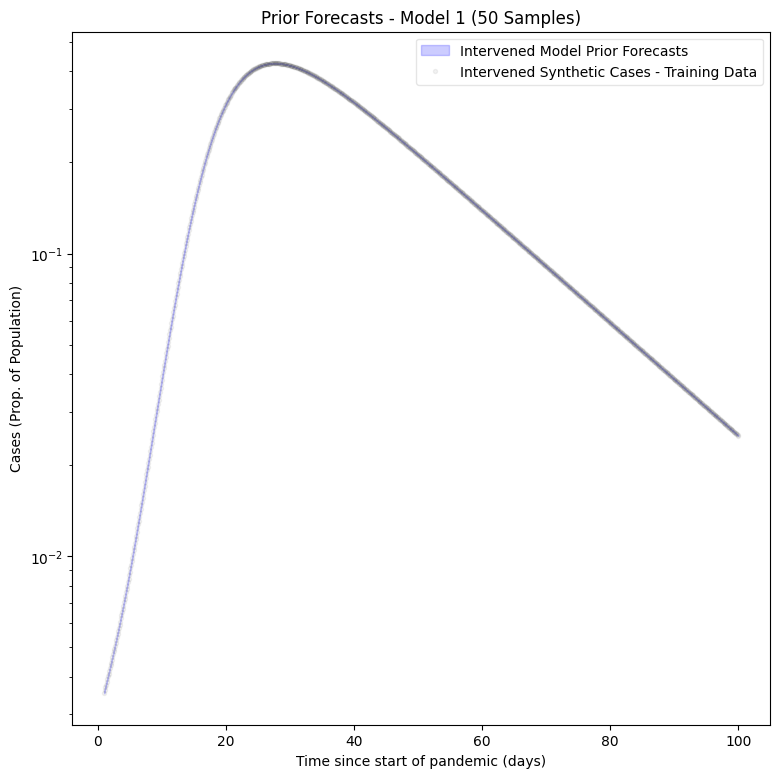

In [30]:
model1_prior_sol_dict = {}
for n in state_var_names:
    model1_prior_sol_dict[n[0:-4]] = model1_prior_forecast[n]

model1_solns = solution_mapping1(model1_prior_sol_dict)

# Fix solution names for plotting
new_model1_solns = {f"{k}_sol":v for k,v in model1_solns.items()}

ax = plot_predictive(new_model1_solns, t_points, ax=setup_ax(), title=f"Prior Forecasts - Model 1 ({num_samples} Samples)", color="blue", label="Intervened Model Prior Forecasts")
ax = plot_observations(synth_data_dict['model1']['Cases'][0], t_points, ax=ax, color="black", alpha = 0.05, label="Intervened Synthetic Cases - Training Data")

#### *Note how the intervened prior distribution collapses to match the generated data, as expected for fixed parameter values. (Change `intervened_model1` to `setup_model1` to compare prior distributions.)* 

## Set up Model 2 and intervene with fixed parameters (NEEDS CORRECTION)

In [31]:
model2

ScaledBetaNoisePetriNetODESystem(
	mira_param_0 = Uniform(low: 8.308957966107755e-10, high: 1.015539319304537e-09),
	mira_param_1 = Uniform(low: 3.398363812578964e-09, high: 4.153555721586599e-09),
	mira_param_2 = Uniform(low: 7.070923291330189e-10, high: 8.642239701650567e-10),
	mira_param_3 = Uniform(low: 0.02098800055682659, high: 0.025652000680565834),
	mira_param_4 = Uniform(low: 0.37501201033592224, high: 0.45834800601005554),
	mira_param_5 = Uniform(low: 0.0494999997317791, high: 0.060499999672174454),
	mira_param_6 = Uniform(low: 0.266400009393692, high: 0.3255999982357025),
	mira_param_7 = Uniform(low: 0.02070000022649765, high: 0.025299999862909317),
	mira_param_8 = Uniform(low: 1.4759999513626099, high: 1.8040000200271606),
	mira_param_9 = Uniform(low: 0.0, high: 0.10000000149011612),
	mira_param_10 = Uniform(low: 0.0002610000083222985, high: 0.00031900001340545714),
	mira_param_11 = Uniform(low: 0.016200000420212746, high: 0.01979999989271164),
	pseudocount = 1.0
)

In [32]:
# Choose model parameter distributions to intervene on selected specific values
# Note that we cannot intervene at a previously existing timepoint, or odeint will complain.
# Intervention format: (time, parameter, value)

model2_rate_parameter_intervention = [
    (intervene_t[0], "mira_param_0", 1),#1e-9),
    (intervene_t[1], "mira_param_1", 4),#4e-9),
    (intervene_t[2], "mira_param_2", 0.85),#8.5e-10),
    (intervene_t[3], "mira_param_3", 0.024),
    (intervene_t[4], "mira_param_4", 0.44),
    (intervene_t[5], "mira_param_5", 0.059),
    (intervene_t[6], "mira_param_6", 0.31),
    (intervene_t[7], "mira_param_7", 0.024),
    (intervene_t[8], "mira_param_8", 1.7),
    (intervene_t[9], "mira_param_9", 0.09),
    (intervene_t[10], "mira_param_10", 0.0003),
    (intervene_t[11], "mira_param_11", 0.019)
]

# Setup model with initial value
setup_model2 = setup_model_petri(model2, start_time=start_t, start_state=start_state2)

# Create intevened model
intervened_model2 = intervene_petri(setup_model2, model2_rate_parameter_intervention)
print(intervened_model2)

# Simulate model predictions by sampling 1 prediction from the intervened model
N_samples = 1
model2_prediction = sample_petri(intervened_model2, timepoints=t_points, num_samples = N_samples)
model2_prediction

ScaledBetaNoisePetriNetODESystem(
	mira_param_0 = Uniform(low: 8.308957966107755e-10, high: 1.015539319304537e-09),
	mira_param_1 = Uniform(low: 3.398363812578964e-09, high: 4.153555721586599e-09),
	mira_param_2 = Uniform(low: 7.070923291330189e-10, high: 8.642239701650567e-10),
	mira_param_3 = Uniform(low: 0.02098800055682659, high: 0.025652000680565834),
	mira_param_4 = Uniform(low: 0.37501201033592224, high: 0.45834800601005554),
	mira_param_5 = Uniform(low: 0.0494999997317791, high: 0.060499999672174454),
	mira_param_6 = Uniform(low: 0.266400009393692, high: 0.3255999982357025),
	mira_param_7 = Uniform(low: 0.02070000022649765, high: 0.025299999862909317),
	mira_param_8 = Uniform(low: 1.4759999513626099, high: 1.8040000200271606),
	mira_param_9 = Uniform(low: 0.0, high: 0.10000000149011612),
	mira_param_10 = Uniform(low: 0.0002610000083222985, high: 0.00031900001340545714),
	mira_param_11 = Uniform(low: 0.016200000420212746, high: 0.01979999989271164),
	pseudocount = 1.0
)


{'mira_param_0': tensor([9.6709e-10]),
 'mira_param_1': tensor([3.9138e-09]),
 'mira_param_2': tensor([8.5339e-10]),
 'mira_param_3': tensor([0.0228]),
 'mira_param_4': tensor([0.4025]),
 'mira_param_5': tensor([0.0548]),
 'mira_param_6': tensor([0.2703]),
 'mira_param_7': tensor([0.0221]),
 'mira_param_8': tensor([1.4930]),
 'mira_param_9': tensor([0.0600]),
 'mira_param_10': tensor([0.0003]),
 'mira_param_11': tensor([0.0167]),
 'Asymptomatic_sol': tensor([[  811361.9375,   838645.8750,   869619.6875,   903702.0000,
            940456.0625,   979554.6250,  1020754.4375,  1063881.2500,
           1108806.2500,  1155446.3750,  1203741.7500,  1253663.0000,
           1305195.5000,  1358337.0000,  1413098.0000,  1469501.0000,
           1527567.1250,  1587328.3750,  1648818.3750,  1712075.2500,
           1777130.5000,  1844032.6250,  1912819.3750,  1983532.2500,
           2056213.5000,  2130903.5000,  2207644.0000,  2286473.5000,
           2367438.2500,  2450568.5000,  2535907.7500,  

### Generate solution from intervened Model 2

In [33]:
print(model2_prediction.keys())

dict_keys(['mira_param_0', 'mira_param_1', 'mira_param_2', 'mira_param_3', 'mira_param_4', 'mira_param_5', 'mira_param_6', 'mira_param_7', 'mira_param_8', 'mira_param_9', 'mira_param_10', 'mira_param_11', 'Asymptomatic_sol', 'Deceased_sol', 'Exposed_sol', 'Hospitalized_sol', 'Infectious_sol', 'Recovered_sol', 'Susceptible_sol'])


In [34]:
#print(model1_prediction.keys())
state_var_names = ['Asymptomatic_sol', 'Deceased_sol', 'Exposed_sol', 'Hospitalized_sol', 'Infectious_sol', 'Recovered_sol', 'Susceptible_sol']
state_var_sol_dict = {}
for n in state_var_names:
    state_var_sol_dict[n[0:-4]] = model2_prediction[n]

synth_data_dict['model2'] = solution_mapping2(state_var_sol_dict)
print(synth_data_dict['model2'].keys())
#print(synth_data_dict['model2'])

dict_keys(['Cases', 'Hospitalizations', 'Dead'])


### Display prior forecasts for Model 2 with intervened observation data

In [35]:
# CAUTION!!! Check the number of samples you are using! 1000 samples is going to take a while...
num_samples = 50
model2_prior_forecast = sample_petri(intervened_model2, timepoints=t_points, num_samples = num_samples)

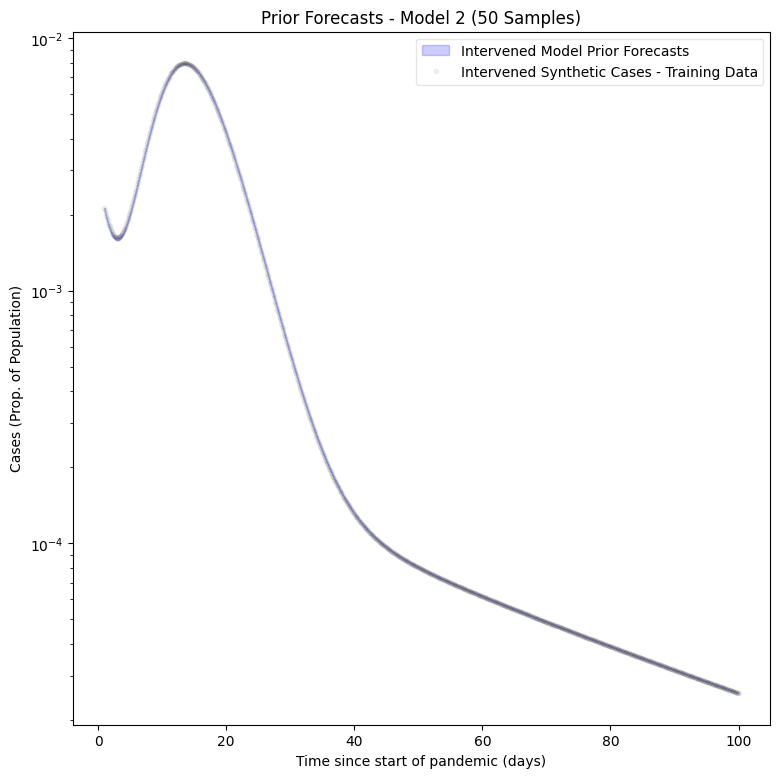

In [36]:
model2_prior_sol_dict = {}
for n in state_var_names:
    model2_prior_sol_dict[n[0:-4]] = model2_prior_forecast[n]

model2_solns = solution_mapping2(model2_prior_sol_dict)

# Fix solution names for plotting
new_model2_solns = {f"{k}_sol":v for k,v in model2_solns.items()}

ax = plot_predictive(new_model2_solns, t_points, ax=setup_ax(), title=f"Prior Forecasts - Model 2 ({num_samples} Samples)", color="blue", label="Intervened Model Prior Forecasts")
ax = plot_observations(synth_data_dict['model2']['Cases'][0], t_points, ax=ax, color="black", alpha = 0.05, label="Intervened Synthetic Cases - Training Data")


#### *Hmmmmmmm....what is going on with Model 2??? This rapid decay to zero cases is unexpected.*

## Setup Model 3 and intervene with fixed parameters (NEEDS CORRECTION)

In [37]:
model3

ScaledBetaNoisePetriNetODESystem(
	mira_param_0 = Uniform(low: 7.614000097078133e-09, high: 9.306000414710525e-09),
	mira_param_1 = Uniform(low: 1.5228000194156266e-08, high: 1.861200082942105e-08),
	mira_param_2 = Uniform(low: 1.9035000242695332e-09, high: 2.326500103677631e-09),
	mira_param_3 = Uniform(low: 3.8070000485390665e-09, high: 4.653000207355262e-09),
	mira_param_4 = Uniform(low: 0.019285714253783226, high: 0.023571427911520004),
	mira_param_5 = Uniform(low: 0.035999998450279236, high: 0.04399999976158142),
	mira_param_6 = Uniform(low: 0.14399999380111694, high: 0.17599999904632568),
	mira_param_7 = Uniform(low: 0.09000000357627869, high: 0.10999999940395355),
	mira_param_8 = Uniform(low: 0.22499999403953552, high: 0.2750000059604645),
	mira_param_9 = Uniform(low: 0.044999998062849045, high: 0.054999999701976776),
	mira_param_10 = Uniform(low: 0.015300000086426735, high: 0.018699999898672104),
	pseudocount = 1.0
)

In [38]:
# Choose model parameter distributions to intervene on selected specific values
# Note that we cannot intervene at a previously existing timepoint, or odeint will complain.
# Intervention format: (time, parameter, value)

model3_rate_parameter_intervention = [
    (intervene_t[0], "mira_param_0", 8e-9),
    (intervene_t[1], "mira_param_1", 1.7e-8),
    (intervene_t[2], "mira_param_2", 2.2e-9),
    (intervene_t[3], "mira_param_3", 4.5e-9),
    (intervene_t[4], "mira_param_4", 0.022),
    (intervene_t[5], "mira_param_5", 0.04),
    (intervene_t[6], "mira_param_6", .17),
    (intervene_t[7], "mira_param_7", .1),
    (intervene_t[8], "mira_param_8", .26),
    (intervene_t[9], "mira_param_9", .05),
    (intervene_t[10], "mira_param_10", .017)
]

# Setup model with initial value
setup_model3 = setup_model_petri(model3, start_time=start_t, start_state=start_state3)

# Create intevened model
intervened_model3 = intervene_petri(setup_model3, model3_rate_parameter_intervention)
print(intervened_model3)

# Simulate model predictions by sampling 1 prediction from the intervened model
N_samples = 1
model3_prediction = sample_petri(intervened_model3, timepoints=t_points, num_samples = N_samples)
model3_prediction

ScaledBetaNoisePetriNetODESystem(
	mira_param_0 = Uniform(low: 7.614000097078133e-09, high: 9.306000414710525e-09),
	mira_param_1 = Uniform(low: 1.5228000194156266e-08, high: 1.861200082942105e-08),
	mira_param_2 = Uniform(low: 1.9035000242695332e-09, high: 2.326500103677631e-09),
	mira_param_3 = Uniform(low: 3.8070000485390665e-09, high: 4.653000207355262e-09),
	mira_param_4 = Uniform(low: 0.019285714253783226, high: 0.023571427911520004),
	mira_param_5 = Uniform(low: 0.035999998450279236, high: 0.04399999976158142),
	mira_param_6 = Uniform(low: 0.14399999380111694, high: 0.17599999904632568),
	mira_param_7 = Uniform(low: 0.09000000357627869, high: 0.10999999940395355),
	mira_param_8 = Uniform(low: 0.22499999403953552, high: 0.2750000059604645),
	mira_param_9 = Uniform(low: 0.044999998062849045, high: 0.054999999701976776),
	mira_param_10 = Uniform(low: 0.015300000086426735, high: 0.018699999898672104),
	pseudocount = 1.0
)


{'mira_param_0': tensor([9.2389e-09]),
 'mira_param_1': tensor([1.6614e-08]),
 'mira_param_2': tensor([2.0945e-09]),
 'mira_param_3': tensor([3.9391e-09]),
 'mira_param_4': tensor([0.0195]),
 'mira_param_5': tensor([0.0419]),
 'mira_param_6': tensor([0.1628]),
 'mira_param_7': tensor([0.1094]),
 'mira_param_8': tensor([0.2667]),
 'mira_param_9': tensor([0.0463]),
 'mira_param_10': tensor([0.0184]),
 'Deceased_sol': tensor([[161085.9531, 161396.1875, 161705.0625, 162012.2969, 162317.9531,
          162622.0000, 162924.4375, 163225.2188, 163524.4844, 163821.9688,
          164117.7344, 164411.7344, 164703.9531, 164994.8906, 165283.8125,
          165570.9375, 165856.3281, 166139.9688, 166421.5625, 166701.4844,
          166979.6250, 167255.9219, 167530.4062, 167803.0156, 168073.7812,
          168342.6719, 168609.7031, 168874.7812, 169137.8750, 169399.7656,
          169659.3438, 169917.0469, 170172.8125, 170426.6562, 170678.5469,
          170929.1875, 171177.5156, 171423.9688, 171668.5

### Generate solution from intervened Model 3

In [39]:
print(model3_prediction.keys())

dict_keys(['mira_param_0', 'mira_param_1', 'mira_param_2', 'mira_param_3', 'mira_param_4', 'mira_param_5', 'mira_param_6', 'mira_param_7', 'mira_param_8', 'mira_param_9', 'mira_param_10', 'Deceased_sol', 'Exposed_sol', 'Infected_reported_sol', 'Infected_unreported_sol', 'Quarantined_sol', 'Recovered_sol', 'Susceptible_unconfined_sol'])


In [40]:
# print(model1_prediction.keys())
state_var_names = ['Deceased_sol', 'Exposed_sol', 'Infected_reported_sol', 'Infected_unreported_sol', 'Quarantined_sol', 'Recovered_sol', 'Susceptible_unconfined_sol']
state_var_sol_dict = {}
for n in state_var_names:
    state_var_sol_dict[n[0:-4]] = model3_prediction[n]

synth_data_dict['model3'] = solution_mapping3(state_var_sol_dict)
print(synth_data_dict['model3'].keys())
#print(synth_data_dict['model3'])

dict_keys(['Cases', 'Hospitalizations', 'Dead'])


### Display prior forecasts for Model 3 with intervened observation data

In [43]:
# CAUTION!!! Check the number of samples you are using! 1000 samples is going to take a while...
num_samples = 50
model3_prior_forecast = sample_petri(intervened_model3, timepoints=t_points, num_samples = num_samples)

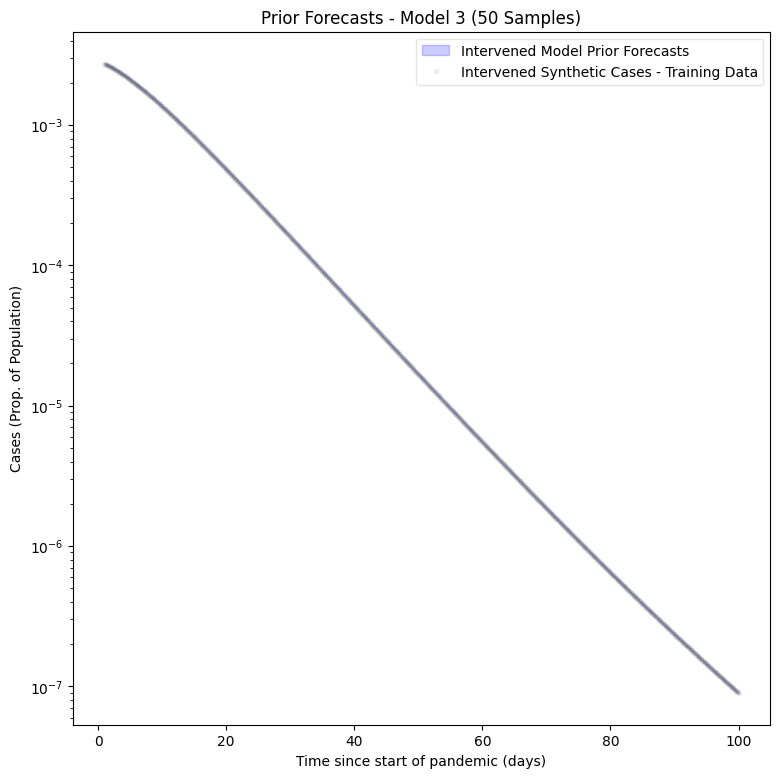

In [44]:
model3_prior_sol_dict = {}
for n in state_var_names:
    model3_prior_sol_dict[n[0:-4]] = model3_prior_forecast[n]

model3_solns = solution_mapping3(model3_prior_sol_dict)

# Fix solution names for plotting
new_model3_solns = {f"{k}_sol":v for k,v in model3_solns.items()}

ax = plot_predictive(new_model3_solns, t_points, ax=setup_ax(), title=f"Prior Forecasts - Model 3 ({num_samples} Samples)", color="blue", label="Intervened Model Prior Forecasts")
ax = plot_observations(synth_data_dict['model3']['Cases'][0], t_points, ax=ax, color="black", alpha = 0.05, label="Intervened Synthetic Cases - Training Data")


#### *Again, this rapid drop to zero cases is odd!*

## Combine data from the three models using prescribed weights

In [45]:
# Assign weights for each model, and create a dictionary
generating_weights = [0.5, 0.3, 0.2]
model_weights = dict(zip(synth_data_dict.keys(), generating_weights))

# Create a df containing the weighted sum of the different model solutions for each variable
model_names = synth_data_dict.keys()
var_names = synth_data_dict['model1'].keys()
new_synth_data_dict = {}
for vn in var_names:
    this_var = 0*synth_data_dict['model1'][vn][0]
    for mn in synth_data_dict.keys():
        this_var = this_var + model_weights[mn]*synth_data_dict[mn][vn][0]
    this_var = this_var*data_total_population # convert from pop percentage to case census counts
    new_synth_data_dict[vn] = this_var.numpy()
synth_data_df = pd.DataFrame.from_dict(new_synth_data_dict)

# Keep only integer time values so there's one data point per day
keep_idx = [i for i,t in enumerate(t_points) if int(t) == t] # np.arange(0, 10*N_t + 1, 10)
synth_data_df = synth_data_df.iloc[keep_idx]

# Add date column
from datetime import date, timedelta, datetime

start_date = date(2021, 12, 1)
date_col = [start_date]*len(synth_data_df)
for i in range(len(synth_data_df)):
    date_col[i] = f"{start_date + timedelta(days = i)}"
    
date_col
synth_data_df["Date"] = date_col #pd.DataFrame(Date = date_col, synth_data_df)
synth_data_df = synth_data_df.iloc[:, [3, 0, 2, 1]]

# Reset dataframe index
synth_data_df = synth_data_df.reset_index(drop = True)

# Change dataframe column names to match expected testing data format
synth_data_df = synth_data_df.rename(columns = {"Date": "date", 
                                                "Cases": "case_census", 
                                                "Dead": "cumulative_deaths", 
                                                "Hospitalizations": "hospital_census"})
#print(synth_data_df["case_census"]/data_total_population)
synth_data_df

,date,case_census,cumulative_deaths,hospital_census
0,2021-12-01,9.814291e+05,8.081012e+05,6.698777e+04
1,2021-12-02,1.068494e+06,8.430269e+05,8.996934e+04
2,2021-12-03,1.222252e+06,8.906320e+05,1.135738e+05
3,2021-12-04,1.462852e+06,9.563044e+05,1.401417e+05
4,2021-12-05,1.818487e+06,1.046176e+06,1.722416e+05
...,...,...,...,...
95,2022-03-06,4.936375e+06,2.153677e+07,1.868125e+07
96,2022-03-07,4.728889e+06,2.170301e+07,1.833539e+07
97,2022-03-08,4.530116e+06,2.186615e+07,1.799285e+07
98,2022-03-09,4.339691e+06,2.202624e+07,1.765372e+07


#### `synth_data_df` *holds the synthetic data constructed as the weighted sum of the output generated separately from the three models*

In [46]:
# Make a separate dataframe to hold output from each model independently
model1_df = pd.DataFrame.from_dict({k: synth_data_dict['model1'][k][0] for k in synth_data_dict['model1']})
model2_df = pd.DataFrame.from_dict({k: synth_data_dict['model2'][k][0] for k in synth_data_dict['model2']})
model3_df = pd.DataFrame.from_dict({k: synth_data_dict['model3'][k][0] for k in synth_data_dict['model3']})

## Plot synthetic data

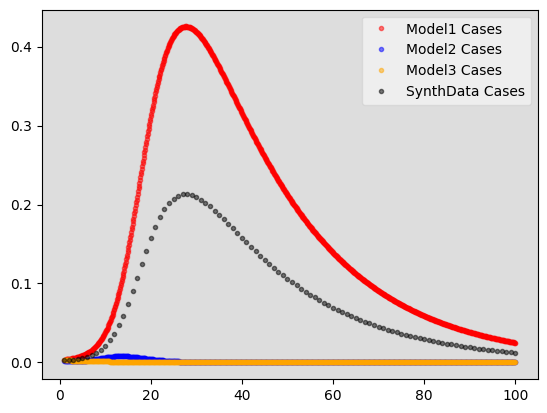

In [47]:
# Display synthetic data by plotting each model trajectory separately, along with the weighted sum data

# NOTE: Add title with weights used 

ax = plot_observations(model1_df['Cases'], t_points, color="red", label="Model1 Cases")
ax = plot_observations(model2_df['Cases'], t_points, ax=ax, color="blue", label="Model2 Cases")
ax = plot_observations(model3_df['Cases'], t_points, ax=ax, color="orange", label="Model3 Cases")
ax = plot_observations(synth_data_df['case_census']/data_total_population, t_points[keep_idx], ax=ax, color="black", label="SynthData Cases")

# Set up and calibrate the ensemble model to synthetic data

In [48]:
# Get train and test data, set start time
train_data, train_cases, train_timepoints, test_cases, test_timepoints, all_timepoints = get_train_test_data(synth_data_df, train_start_date, test_start_date, test_end_date)
start_time = train_timepoints[0] - 1e-5

In [50]:
# Set up the ensemble model

models = [intervened_model1, intervened_model2, intervened_model3]
# models = [setup_model1, setup_model2, setup_model3]
ensemble_weights = [1/3, 1/3, 1/3]

start_states = [start_state1, start_state2, start_state3]
solution_mappings = [solution_mapping1, solution_mapping2, solution_mapping3]

ensemble_total_population = 1.0
dirichlet_concentration = 1.0
noise_pseudocount = 100.0

ensemble = setup_model_ensemble(models, 
                       ensemble_weights, 
                       solution_mappings, 
                       start_time, 
                       start_states, 
                       ensemble_total_population, 
                       dirichlet_concentration=dirichlet_concentration,
                       noise_pseudocount=noise_pseudocount)
ensemble

Ensemble of 3 models. 

 	Dirichlet Alpha: tensor([0.3333, 0.3333, 0.3333]). 

 	Models: [ScaledBetaNoisePetriNetODESystem(
	beta = Uniform(low: 0.00989999994635582, high: 0.01209999993443489),
	gamma = Uniform(low: 0.41040000319480896, high: 0.5016000270843506),
	delta = Uniform(low: 0.00989999994635582, high: 0.01209999993443489),
	alpha = Uniform(low: 0.5130000114440918, high: 0.6269999742507935),
	epsilon = Uniform(low: 0.15389999747276306, high: 0.18809999525547028),
	zeta = Uniform(low: 0.11249999701976776, high: 0.13750000298023224),
	XXlambdaXX = Uniform(low: 0.03060000017285347, high: 0.03739999979734421),
	eta = Uniform(low: 0.11249999701976776, high: 0.13750000298023224),
	rho = Uniform(low: 0.03060000017285347, high: 0.03739999979734421),
	theta = Uniform(low: 0.33390000462532043, high: 0.4081000089645386),
	kappa = Uniform(low: 0.015300000086426735, high: 0.018699999898672104),
	mu = Uniform(low: 0.015300000086426735, high: 0.018699999898672104),
	nu = Uniform(low: 0.02429

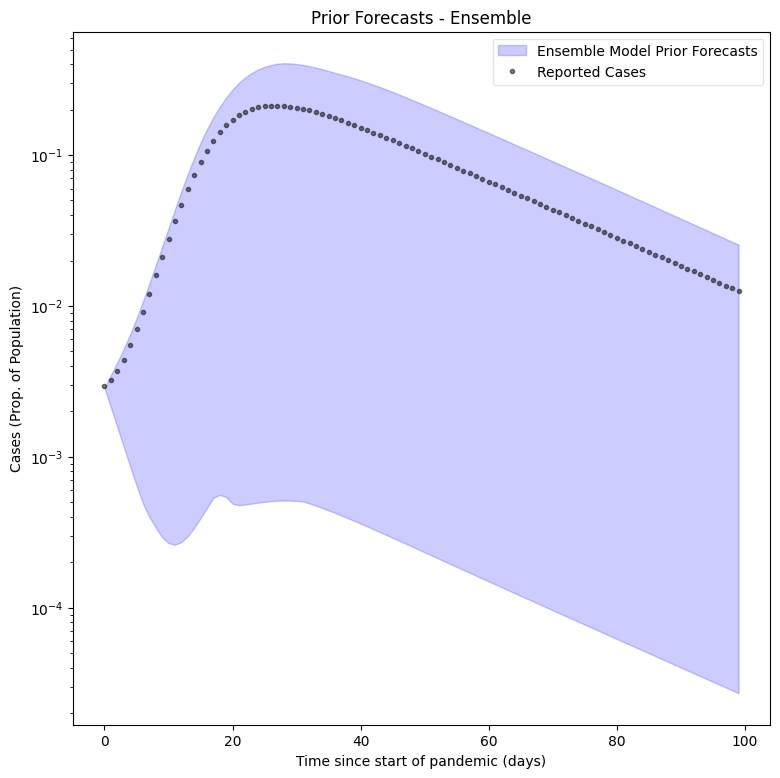

In [52]:
# Sample from the ensemble prior
ensemble_prior_forecasts = sample_ensemble(ensemble, all_timepoints, num_samples)
ax = plot_predictive(ensemble_prior_forecasts, all_timepoints, ax=setup_ax(), title="Prior Forecasts - Ensemble", color="blue", label="Ensemble Model Prior Forecasts")
ax = plot_observations(synth_data_df['case_census']/data_total_population, all_timepoints, ax=ax, color="black", label="Reported Cases")

<Axes: title={'center': 'Prior Ensemble Weights'}>

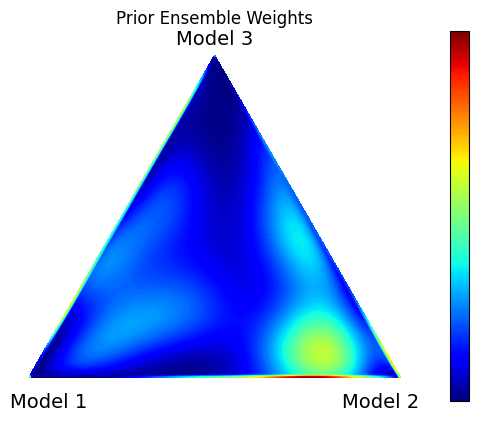

In [53]:
# Plot prior ensemble weights
# TODO: Include interpretation of this plot!
plot_weights(ensemble_prior_forecasts["model_weights"], title="Prior Ensemble Weights")

## Calibrate ensemble model

In [54]:
num_iterations = 50

In [55]:
import pyro 

autoguide = pyro.infer.autoguide.AutoDiagonalNormal
inferred_parameters = calibrate_ensemble(ensemble, train_data, num_iterations=num_iterations, verbose=True, verbose_every=10, autoguide=autoguide)

inferred_parameters

iteration 0: loss = -495.8099559545517
iteration 10: loss = -561.4974159002304
iteration 20: loss = -667.6097930669785
iteration 30: loss = -694.5280092954636
iteration 40: loss = -706.8676835298538


AutoDiagonalNormal()

In [56]:
calibrated_solution = sample_ensemble(ensemble, timepoints=all_timepoints, num_samples=30, inferred_parameters=inferred_parameters)
#calibrated_solution

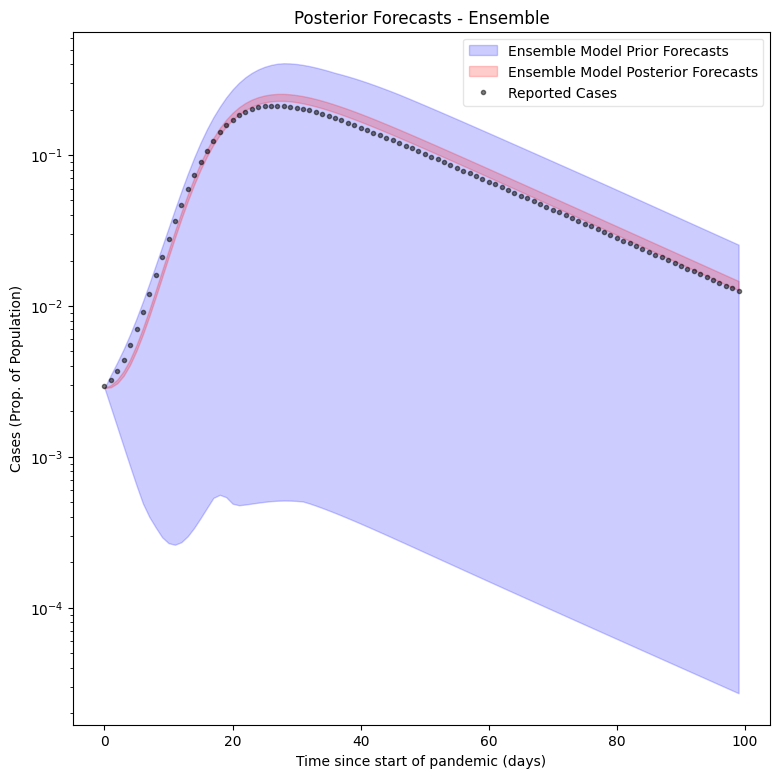

In [57]:
# Plot ensemble output with synthetic data
ax = plot_predictive(ensemble_prior_forecasts, all_timepoints, ax=setup_ax(), title="Prior Forecasts - Ensemble", color="blue", label="Ensemble Model Prior Forecasts")
ax = plot_predictive(calibrated_solution, all_timepoints, ax=ax, title="Posterior Forecasts - Ensemble", color="red", label="Ensemble Model Posterior Forecasts")
ax = plot_observations(synth_data_df['case_census']/data_total_population, all_timepoints, ax=ax, color="black", label="Reported Cases")

## Compare posterior ensemble weights to original generating weights

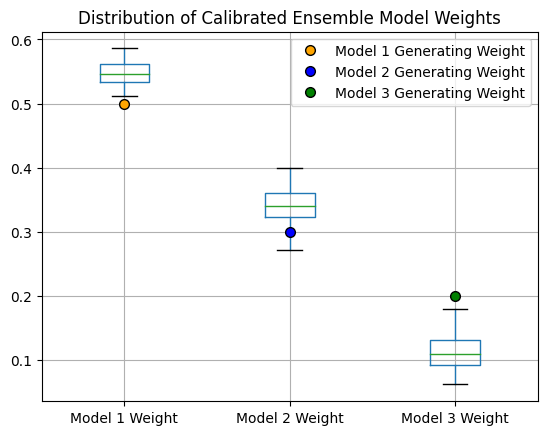

In [58]:
# Make a box plot of model weights from each sample
calibrated_solution["model_weights"][:, 0]
weight_df = pd.DataFrame({"Model 1 Weight": calibrated_solution["model_weights"][:, 0], 
                         "Model 2 Weight": calibrated_solution["model_weights"][:, 1],
                         "Model 3 Weight": calibrated_solution["model_weights"][:, 2]})
weight_df.boxplot()
plt.plot(1, generating_weights[0], mfc = "orange", mec='k', ms=7, marker="o", linestyle="None", label="Model 1 Generating Weight")
plt.plot(2, generating_weights[1], mfc = "blue", mec='k', ms=7, marker="o", linestyle="None", label="Model 2 Generating Weight")
plt.plot(3, generating_weights[2], mfc = "green", mec='k', ms=7, marker="o", linestyle="None", label="Model 3 Generating Weight")
plt.title("Distribution of Calibrated Ensemble Model Weights")
plt.legend()

<Axes: title={'center': 'Posterior Ensemble Weights'}>

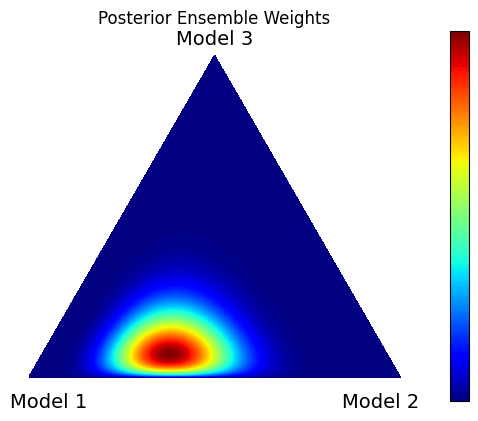

In [59]:
# Print calibrated model weights for ensemble at last iteration
plot_weights(calibrated_solution["model_weights"], title="Posterior Ensemble Weights")

# XXXX *IGNORE EVERYTHING AFTER THIS POINT (FOR NOW). MUCH IS COPIED FROM THE APRIL ENSEMBLE DEMO NOTEBOOK* XXXX

### Calibrate Model 1 using Model 1 data

In [ ]:
synth_data_model1 = pd.DataFrame.from_dict({
    'date': synth_data_df['date'],
    'case_census': synth_data_dict['model1']['Cases'][0][keep_idx]*data_total_population,
    'cumulative_deaths': synth_data_dict['model1']['Dead'][0][keep_idx]*data_total_population,
    'hospital_census': synth_data_dict['model1']['Hospitalizations'][0][keep_idx]*data_total_population,
})
synth_data_model1

In [ ]:
train_data, train_cases, train_timepoints, test_cases, test_timepoints, all_timepoints = get_train_test_data(synth_data_model1, train_start_date, test_start_date, test_end_date)

In [ ]:
ensemble1on1 = setup_model([model1], weights=[1.0], start_time=start_t-1e-6, start_states=[start_state1], solution_mappings=[solution_mapping1])

inferred_parameters1on1 = calibrate(ensemble1on1, train_data, num_iterations=num_iterations, verbose=True, verbose_every=10, autoguide=autoguide)

ensemble_posterior_forecasts1on1 = sample(ensemble1on1, t_points, num_samples, inferred_parameters1on1)

In [ ]:
train_cases

In [ ]:
# Cases
ax = plot_predictive(ensemble_posterior_forecasts1on1, t_points, var_name="Cases_sol", ax=setup_ax(), color="green", label="Model1on1 Cases Posterior Forecasts")
ax = plot_observations(train_cases, train_timepoints, ax=ax, color="black", label="Reported Cases - Training Data")
ax = plot_observations(test_cases, test_timepoints, ax=ax, color="red", label="Reported Cases - Testing Data")

# Hospitalizations
train_df = synth_data_model1[(synth_data_model1['date'] >= train_start_date) & (synth_data_model1['date'] < test_start_date)]
test_df = synth_data_model1[(synth_data_model1['date'] >= test_start_date) & (synth_data_model1['date'] < test_end_date)]

train_hosps = np.array(train_df["hospital_census"].astype("float")) / data_total_population
test_hosps = np.array(test_df["hospital_census"].astype("float")) / data_total_population

train_dead = np.array(train_df["cumulative_deaths"].astype("float")) / data_total_population
test_dead = np.array(test_df["cumulative_deaths"].astype("float")) / data_total_population



ax = plot_predictive(ensemble_posterior_forecasts1on1, t_points, var_name="Hospitalizations_sol", ax=ax, color="blue", label="Model1on1 Hospitalizations Posterior Forecasts")
ax = plot_observations(train_hosps, train_timepoints, ax=ax, color="black", marker='x', label="Reported Hospitalizations - Training Data")
ax = plot_observations(test_hosps, test_timepoints, ax=ax, color="red", marker='x', label="Reported Hospitalizations - Testing Data")

ax = plot_predictive(ensemble_posterior_forecasts1on1, t_points, var_name="Dead_sol", ax=ax, color="orange", label="Model1on1 Dead Posterior Forecasts")
ax = plot_observations(train_dead, train_timepoints, ax=ax, color="black", marker='^', label="Reported Dead - Training Data")
ax = plot_observations(test_dead, test_timepoints, ax=ax, color="red", marker='^', label="Reported Dead - Testing Data")


In [ ]:
param_median = {k[8:]: v[0].item() for k,v in inferred_parameters1on1.quantiles([0.50]).items()}
display(param_median)

param_actual = {b: c for (a,b,c) in model1_rate_parameter_intervention}
display(param_actual)

param_errs = {k:(v-param_median[k])/v for k,v in param_actual.items()}
display(param_errs)

### Calibrate Model 2 using Model 2 data

In [ ]:
synth_data_model2 = pd.DataFrame.from_dict({
    'date': synth_data_df['date'],
    'case_census': synth_data_dict['model2']['Cases'][0][keep_idx]*data_total_population,
    'cumulative_deaths': synth_data_dict['model2']['Dead'][0][keep_idx]*data_total_population,
    'hospital_census': synth_data_dict['model2']['Hospitalizations'][0][keep_idx]*data_total_population,
})
synth_data_model2

In [ ]:
train_data, train_cases, train_timepoints, test_cases, test_timepoints, all_timepoints = get_train_test_data(synth_data_model2, train_start_date, test_start_date, test_end_date)

In [ ]:
ensemble2on2 = setup_model([model2], weights=[1.0], start_time=start_t-1e-6, start_states=[start_state2], solution_mappings=[solution_mapping2])

inferred_parameters2on2 = calibrate(ensemble2on2, train_data, num_iterations=num_iterations, verbose=True, verbose_every=10, autoguide=autoguide)

ensemble_posterior_forecasts2on2 = sample(ensemble2on2, t_points, num_samples, inferred_parameters2on2)

In [ ]:
# Cases
ax = plot_predictive(ensemble_posterior_forecasts2on2, t_points, var_name="Cases_sol", ax=setup_ax(), color="green", label="Model2on2 Cases Posterior Forecasts")
ax = plot_observations(train_cases, train_timepoints, ax=ax, color="black", label="Reported Cases - Training Data")
ax = plot_observations(test_cases, test_timepoints, ax=ax, color="red", label="Reported Cases - Testing Data")

# Hospitalizations
train_df = synth_data_model2[(synth_data_model2['date'] >= train_start_date) & (synth_data_model2['date'] < test_start_date)]
test_df = synth_data_model2[(synth_data_model2['date'] >= test_start_date) & (synth_data_model2['date'] < test_end_date)]

train_hosps = np.array(train_df["hospital_census"].astype("float")) / data_total_population
test_hosps = np.array(test_df["hospital_census"].astype("float")) / data_total_population

train_dead = np.array(train_df["cumulative_deaths"].astype("float")) / data_total_population
test_dead = np.array(test_df["cumulative_deaths"].astype("float")) / data_total_population



ax = plot_predictive(ensemble_posterior_forecasts2on2, t_points, var_name="Hospitalizations_sol", ax=ax, color="blue", label="Model2on2 Hospitalizations Posterior Forecasts")
ax = plot_observations(train_hosps, train_timepoints, ax=ax, color="black", marker='x', label="Reported Hospitalizations - Training Data")
ax = plot_observations(test_hosps, test_timepoints, ax=ax, color="red", marker='x', label="Reported Hospitalizations - Testing Data")

ax = plot_predictive(ensemble_posterior_forecasts2on2, t_points, var_name="Dead_sol", ax=ax, color="orange", label="Model2on2 Dead Posterior Forecasts")
ax = plot_observations(train_dead, train_timepoints, ax=ax, color="black", marker='^', label="Reported Dead - Training Data")
ax = plot_observations(test_dead, test_timepoints, ax=ax, color="red", marker='^', label="Reported Dead - Testing Data")


In [ ]:
param_median = {k[8:]: v[0].item() for k,v in inferred_parameters2on2.quantiles([0.50]).items()}
display(param_median)

param_actual = {b: c for (a,b,c) in model2_rate_parameter_intervention}
display(param_actual)

param_errs = {k:(v-param_median[k])/v for k,v in param_actual.items()}
display(param_errs)

## Test model calibration for each model separately using the synthetic data as the training dataset

### Calibrate Model 1 using weighted sum synthetic data

In [ ]:
train_data, train_cases, train_timepoints, test_cases, test_timepoints, all_timepoints = get_train_test_data(synth_data_df, train_start_date, test_start_date, test_end_date)

In [ ]:
# train_data.pop(0)

In [ ]:
train_data

In [ ]:
# Run calibration and produce forecast samples
ensemble1 = setup_model([model1], weights=[1.0], start_time=-1, start_states=[start_state1], solution_mappings=[solution_mapping1])
inferred_parameters1 = calibrate(ensemble1, train_data, num_iterations=num_iterations, verbose=True, verbose_every=10, autoguide=autoguide)
ensemble_posterior_forecasts = sample(ensemble1, t_points, num_samples, inferred_parameters1)

In [ ]:
# Plot forecast vs. training/testing data
ax = plot_predictive(ensemble_posterior_forecasts, t_points, ax=setup_ax(), color="green", label="Ensemble Model Posterior Forecasts")
ax = plot_observations(train_cases, train_timepoints, ax=ax, color="black", label="Reported Cases - Training Data")
ax = plot_observations(test_cases, test_timepoints, ax=ax, color="red", label="Reported Cases - Testing Data")

In [ ]:
# for p in inferred_parameters1.parameters():
#     print(p)
    
param_median = {k[8:]: v[0].item() for k,v in inferred_parameters1.quantiles([0.50]).items()}
display(param_median)

param_actual = {b: c for (a,b,c) in model1_rate_parameter_intervention}
display(param_actual)

param_errs = {k:(v-param_median[k])/v for k,v in param_actual.items()}
display(param_errs)


## Test ensemble model calibration using synthetic data as the training dataset

In [ ]:
# Redefine start states for synthetic testing data

synth_train_start_date = synth_data_df["date"][0]
synth_test_end_date = synth_data_df["date"][len(synth_data_df) - 1]
synth_test_start_date = synth_data_df["date"][30]

test_dates = pd.date_range(start=synth_train_start_date, end=synth_test_end_date, freq="1D")
test_dates = [date.strftime("%Y-%m-%d") for date in test_dates[1:-1]]
train_data, train_cases, train_timepoints, test_cases, test_timepoints, all_timepoints = get_train_test_data(synth_data_df, 
                                                                                                             synth_train_start_date, 
                                                                                                             synth_test_start_date, 
                                                                                                             synth_test_end_date)

synth_start_state1 = create_start_state1(synth_data_df, synth_train_start_date, data_total_population)
print("Start state 1", start_state1)

synth_start_state2 = create_start_state2(synth_data_df, synth_train_start_date, data_total_population)
print("Start state 2", start_state2)

synth_start_state3 = create_start_state3(synth_data_df, synth_train_start_date)
print("Start state 3", start_state3)

In [ ]:
# Setup the Ensemble

models = [model1, model2, model3]
weights = [1/3, 1/3, 1/3]

start_t = train_timepoints[0] - 1e-5
start_states = [start_state1, start_state2, start_state3]
solution_mappings = [solution_mapping1, solution_mapping2, solution_mapping3]

ensemble_total_population = 1.0
dirichlet_concentration = 1.0
noise_pseudocount = 100.0

ensemble = setup_model(models, 
                       weights, 
                       solution_mappings, 
                       start_t, 
                       start_states, 
                       ensemble_total_population, 
                       dirichlet_concentration=dirichlet_concentration,
                       noise_pseudocount=noise_pseudocount)
ensemble

In [ ]:
data_total_population

In [ ]:
# Sample from the Ensemble
num_samples = 100
ensemble_prior_forecasts = sample(ensemble, all_timepoints, num_samples)

plotting_cases = np.array(synth_data_df["case_census"][all_timepoints.astype("int")].astype("float")) / data_total_population

ax = plot_predictive(ensemble_prior_forecasts, all_timepoints, ax=setup_ax(), title="Prior Forecasts - Ensemble", color="blue", label="Ensemble Model Prior Forecasts")
ax = plot_observations(plotting_cases, all_timepoints, ax=ax, color="black", label="Reported Cases")

In [ ]:
# Calibrate

num_iterations = 100

import pyro
import dill

save_path = "notebook/april_ensemble/saved_guides/"

try:
    with open(os.path.join(save_path, "inferred_parameters.pkl"), "rb") as f:
        inferred_parameters = dill.load(f)
    print("Loaded inferred parameters from file.")
except:
    autoguide = pyro.infer.autoguide.AutoDiagonalNormal
    inferred_parameters = calibrate(ensemble, train_data, num_iterations=num_iterations, verbose=True, verbose_every=10, autoguide=autoguide)

    with open(os.path.join(save_path, "inferred_parameters.pkl"), "wb") as f:
        dill.dump(inferred_parameters, f)

## Prior samples from each individual model

In [ ]:
num_samples = 5 #100

start_time = train_timepoints[0] - 1e-5

# Wrapping model1 in a single "ensemble" model automatically applies the solution mapping functions, making these three models easier to compare.
ensemble1 = setup_model([model1], weights=[1.0], start_time=start_time, start_states=[start_state1], solution_mappings=[solution_mapping1])
ensemble1_prior_forecasts = sample(ensemble1, all_timepoints, num_samples)

ensemble2 = setup_model([model2], weights=[1.0], start_time=start_time, start_states=[start_state2], solution_mappings=[solution_mapping2])
ensemble2_prior_forecasts = sample(ensemble2, all_timepoints, num_samples)

ensemble3 = setup_model([model3], weights=[1.0], start_time=start_time, start_states=[start_state3], solution_mappings=[solution_mapping3])
ensemble3_prior_forecasts = sample(ensemble3, all_timepoints, num_samples)

plotting_cases = np.array(data["case_census"][all_timepoints].astype("float")) / data_total_population

# Plot trajectories from the prior.
ax = plot_predictive(ensemble1_prior_forecasts, all_timepoints, title="Prior Forecasts - Individual Models", ax=setup_ax(), color="blue", label="Model 1 Prior Forecasts")
ax = plot_predictive(ensemble2_prior_forecasts, all_timepoints, ax=ax, color="red", label="Model 2 Prior Forecasts")
ax = plot_predictive(ensemble3_prior_forecasts, all_timepoints, ax=ax, color="green", label="Model 3 Prior Forecasts")
ax = plot_observations(plotting_cases, all_timepoints, ax=ax, color="black", label="Reported Cases")

## NOTE: The MIRA models did not contain enough information to align the data with the start state. We constructed somewhat handwavy mappings manually based on data.

## Setup the full ensemble of all three models

In [ ]:
# Setup the Ensemble

models = [model1, model2, model3]
weights = [1/3, 1/3, 1/3]

start_states = [start_state1, start_state2, start_state3]
solution_mappings = [solution_mapping1, solution_mapping2, solution_mapping3]

ensemble_total_population = 1.0
dirichlet_concentration = 1.0
noise_pseudocount = 100.0

ensemble = setup_model(models, 
                       weights, 
                       solution_mappings, 
                       start_time, 
                       start_states, 
                       ensemble_total_population, 
                       dirichlet_concentration=dirichlet_concentration,
                       noise_pseudocount=noise_pseudocount)
ensemble

In [ ]:
# Sample from the Ensemble
ensemble_prior_forecasts = sample(ensemble, all_timepoints, num_samples)
ax = plot_predictive(ensemble_prior_forecasts, all_timepoints, ax=setup_ax(), title="Prior Forecasts - Ensemble", color="blue", label="Ensemble Model Prior Forecasts")
ax = plot_observations(plotting_cases, all_timepoints, ax=ax, color="black", label="Reported Cases")

In [ ]:
plot_weights(ensemble_prior_forecasts["model_weights"], title="Prior Ensemble Weights")


## Calibration

In [ ]:
num_iterations = 100

In [ ]:
import pyro
import dill

save_path = "notebook/april_ensemble/saved_guides/"

try:
    with open(os.path.join(save_path, "inferred_parameters.pkl"), "rb") as f:
        inferred_parameters = dill.load(f)
    print("Loaded inferred parameters from file.")
except:
    autoguide = pyro.infer.autoguide.AutoDiagonalNormal
    inferred_parameters = calibrate(ensemble, train_data, num_iterations=num_iterations, verbose=True, verbose_every=10, autoguide=autoguide)

    with open(os.path.join(save_path, "inferred_parameters.pkl"), "wb") as f:
        dill.dump(inferred_parameters, f)

In [ ]:
try:
    with open(os.path.join(save_path, "deterministic_parameters.pkl"), "rb") as f:
        deterministic_parameters = dill.load(f)
    print("Loaded deterministic parameters from file.")
except: 
    deterministic_autoguide = pyro.infer.autoguide.AutoDelta
    deterministic_parameters = calibrate(ensemble, train_data, num_iterations=num_iterations, verbose=True, verbose_every=10, autoguide=deterministic_autoguide)

    with open(os.path.join(save_path, "deterministic_parameters.pkl"), "wb") as f:
        dill.dump(deterministic_parameters, f)

In [ ]:
ensemble_posterior_forecasts = sample(ensemble, all_timepoints, num_samples, inferred_parameters)
ensemble_deterministic_forecasts = sample(ensemble, all_timepoints, 1, deterministic_parameters)

In [ ]:
# Sample from the Ensemble
ax = plot_predictive(ensemble_prior_forecasts, all_timepoints, ax=setup_ax(), color="blue", label="Ensemble Model Prior Forecasts")
ax = plot_predictive(ensemble_posterior_forecasts, all_timepoints, ax=ax, color="green", label="Ensemble Model Posterior Forecasts")
ax = plot_trajectory(ensemble_deterministic_forecasts, all_timepoints, ax=ax, color="orange", label="Ensemble Model Deterministic Forecasts")
ax = plot_observations(train_cases, train_timepoints, ax=ax, color="black", label="Reported Cases - Training Data")
ax = plot_observations(test_cases, test_timepoints, ax=ax, color="red", label="Reported Cases - Testing Data")

In [ ]:
plot_weights(ensemble_posterior_forecasts["model_weights"], title="Posterior Ensemble Weights")

## Forecasting over time - Sliding Window Calibration

In [ ]:
sliding_window_train_start_date = "2020-08-01"
sliding_window_train_end_date = "2022-01-15"

In [ ]:
dates = pd.date_range(start=sliding_window_train_start_date, end=test_end_date, freq="14D")
dates = [date.strftime("%Y-%m-%d") for date in dates[1:-1]]

In [ ]:
# Setup plt axes
fig, axes = plt.subplots(nrows=len(dates)-2, ncols=2, figsize=(10, 3*len(dates)))

for i in range(1, len(dates)-1):
    _train_start_date = dates[i-1]
    _test_start_date = dates[i]
    _test_end_date = dates[i+1]
    print(f"Running analysis for sliding window starting at {_train_start_date}")
    
    _train_data, _train_cases, _train_timepoints, _test_cases, _test_timepoints, _all_timepoints = get_train_test_data(data, _train_start_date, _test_start_date, _test_end_date)
    _start_states = [create_start_state1(data, _train_start_date), create_start_state2(data, _train_start_date), create_start_state3(data, _train_start_date)]
    _start_time = _train_timepoints[0] - 1e-5

    _ensemble = setup_model(models, 
                        weights, 
                        solution_mappings, 
                        _start_time, 
                        _start_states, 
                        ensemble_total_population, 
                        dirichlet_concentration=dirichlet_concentration,
                        noise_pseudocount=noise_pseudocount)
    
    _ensemble_prior_forecasts = sample(_ensemble, _all_timepoints, num_samples)

    try:
        with open(os.path.join(save_path, f"inferred_parameters_{_train_start_date}.pkl"), "rb") as f:
            _inferred_parameters = dill.load(f)
    except:
        _autoguide = pyro.infer.autoguide.AutoDiagonalNormal
        _inferred_parameters = calibrate(_ensemble, _train_data, num_iterations=num_iterations, autoguide=_autoguide)

        with open(os.path.join(save_path, f"inferred_parameters_{_train_start_date}.pkl"), "wb") as f:
            dill.dump(_inferred_parameters, f)

    _ensemble_posterior_forecasts = sample(_ensemble, _all_timepoints, num_samples, _inferred_parameters)

    try:
        with open(os.path.join(save_path, f"deterministic_parameters_{_train_start_date}.pkl"), "rb") as f:
            _deterministic_parameters = dill.load(f)
    except:
        _deterministic_autoguide = pyro.infer.autoguide.AutoDelta
        _deterministic_parameters = calibrate(_ensemble, _train_data, num_iterations=num_iterations, autoguide=_deterministic_autoguide)
        _ensemble_deterministic_forecasts = sample(_ensemble, _all_timepoints, 1, _deterministic_parameters)

        with open(os.path.join(save_path, f"deterministic_parameters_{_train_start_date}.pkl"), "wb") as f:
            dill.dump(_deterministic_parameters, f)
    
    ax = setup_ax(axes[i-1, 0])
    ax = plot_predictive(_ensemble_prior_forecasts, _all_timepoints, ax=ax, color="blue", label="Prior")
    ax = plot_predictive(_ensemble_posterior_forecasts, _all_timepoints, ax=ax, color="green", label="Posterior")
    ax = plot_trajectory(_ensemble_deterministic_forecasts, _all_timepoints, ax=ax, color="orange", label="Deterministic")
    ax = plot_observations(_train_cases, _train_timepoints, ax=ax, color="black", label="Training")
    ax = plot_observations(_test_cases, _test_timepoints, ax=ax, color="red", label="Testing")
    
    plot_weights(_ensemble_posterior_forecasts["model_weights"], ax=axes[i-1, 1])